In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/phd/project_af')

In [4]:
# pip install sklearn==0.23.1 

In [5]:
# pip install torch

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
## Progress bar
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder # need to upgrade to new version

import scipy.io

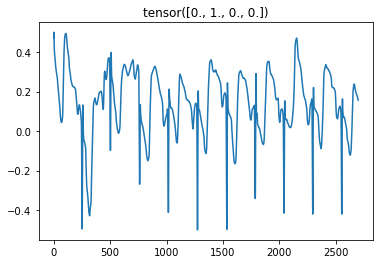

In [10]:

  
# x_test, y_test, x_spec_test = preprocess(data.iloc[1:10,:]) # for testing use
# x, y, x_spec = preprocess(data)
x_train, y_train, x_spec_train = preprocess(data.loc[data.iloc[:,2701]=="train",:])
x_valid, y_valid, x_spec_valid = preprocess(data.loc[data.iloc[:,2701]=="valid",:])
x_test, y_test, x_spec_test = preprocess(data.loc[data.iloc[:,2701]=="test",:])



# visualize one of the signals in data set
plt.plot(x_test[5,0,:])
#plt.axis("off")
plt.title(str(y_test[5]))
plt.show();

# # visualize one of the spectrograms in data set
# plt.imshow(x_spec_test[5,:,:,:].permute(1,2,0))
# #plt.axis("off")
# plt.title(str(y_test[5]))
# plt.show

In [12]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(x_train) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_valid, y_valid)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = False)

52


# Conv1d

In [ ]:
# data shape check
o, _ = preprocess(data)
print(o.shape)
m = nn.ReLU(nn.Conv1d(in_channels = 1, out_channels = 100, kernel_size = 100, padding='same'))
o = m(o)
print(o.shape)
m = nn.ReLU(nn.Conv1d(in_channels = 100, out_channels = 50, kernel_size = 50, padding='same'))
o = m(o)
print(o.shape)
m = nn.MaxPool1d(kernel_size = 100, stride=10)
o = m(o)
print(o.shape)
m = nn.ReLU(nn.Conv1d(in_channels = 261, out_channels = 50, kernel_size = 50, padding='same'))
o = m(o)
print(o.shape)
m = nn.ReLU(nn.Conv1d(in_channels = 261, out_channels = 50, kernel_size = 50, padding='same'))
o = m(o)
print(o.shape)
m = nn.MaxPool1d(kernel_size = 50, stride=10)
o = m(o)
print(o.shape)
m = nn.ReLU(nn.Conv1d(in_channels = 22, out_channels = 50, kernel_size = 50, padding='same'))
o = m(o)
print(o.shape)
m = nn.ReLU(nn.Conv1d(in_channels = 22, out_channels = 50, kernel_size = 50, padding='same'))
o = m(o)
print(o.shape)
m = nn.MaxPool1d(kernel_size = 10, stride=1)
o = m(o)
print(o.shape)

torch.Size([27398, 1, 2700])
torch.Size([27398, 1, 2700])
torch.Size([27398, 1, 2700])
torch.Size([27398, 1, 261])
torch.Size([27398, 1, 261])
torch.Size([27398, 1, 261])
torch.Size([27398, 1, 22])
torch.Size([27398, 1, 22])
torch.Size([27398, 1, 22])
torch.Size([27398, 1, 13])


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device", device)

class cnn_conv1d(nn.Module):

    def __init__(self, dim_out):
        super().__init__()
        self.conv_relu1 = nn.ReLU(nn.Conv1d(in_channels = 1, out_channels = 100, kernel_size = 100, padding='same'))
        self.conv_relu2 = nn.ReLU(nn.Conv1d(in_channels = 100, out_channels = 50, kernel_size = 50, padding='same'))
        self.pool1 = nn.MaxPool1d(kernel_size = 100, stride=10)
        # self.conv_relu3 = nn.ReLU(nn.Conv1d(in_channels = 261, out_channels = 50, kernel_size = 50, padding='same'))
        # self.conv_relu4 = nn.ReLU(nn.Conv1d(in_channels = 261, out_channels = 50, kernel_size = 50, padding='same'))
        # self.pool2 = nn.MaxPool1d(kernel_size = 50, stride=10)
        # self.conv_relu5 = nn.ReLU(nn.Conv1d(in_channels = 22, out_channels = 50, kernel_size = 50, padding='same'))
        # self.conv_relu6 = nn.ReLU(nn.Conv1d(in_channels = 22, out_channels = 50, kernel_size = 50, padding='same'))
        # self.pool3 = nn.MaxPool1d(kernel_size = 10, stride=1)
        self.flat = nn.Flatten()
        self.linear = nn.LazyLinear(dim_out)

    def forward(self, x):
        x = self.conv_relu1(x)
        x = self.conv_relu2(x)
        x = self.pool1(x)
        # x = self.conv_relu3(x)
        # x = self.conv_relu4(x)
        # x = self.pool2(x)
        # x = self.conv_relu5(x)
        # x = self.conv_relu6(x)
        # x = self.pool3(x)
        x = self.flat(x)
        x = self.linear(x)

        return x


Device cuda


In [ ]:
model = cnn_conv1d(dim_out=4).to(device) # we have 4 classes of output
loss_module = nn.CrossEntropyLoss()


In [ ]:
def eval_model(model, data_loader, evalon):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        preds = torch.empty(0,4).to(device)
        trues = torch.empty(0,4).to(device)

        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            pred_l = torch.max(model(data_inputs).data, 1)[1]
            data_l = torch.max(data_labels, 1)[1] # convert onehot responce to labels

            # concatenate predicted values of all batchs of current epoch, is there more efficient way of collecting predictions?
            preds = torch.cat((preds, model(data_inputs)), 0)
            trues = torch.cat((trues, data_labels), 0)

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_l == data_l).sum()
            num_preds += data_labels.shape[0]


    # accuracy
    acc = true_preds / num_preds # this is a tensor object
    acc = acc.to('cpu').numpy().reshape(-1)[0] # this is probably a stupid way to get the value out of a tensor
    # loss
    loss = loss_module(preds, trues)

    print("Accuracy on "+str(evalon)+f": {100.0*acc:4.2f}%" + f" loss: {loss:1.4f}")
    return loss, acc




def train_model(model, optimizer, data_loader, loss_module, num_epochs):
    # Set model to train mode
    model.train()

    # Training loop
    train_loss_trace = list()
    train_acc_trace = list()
    valid_loss_trace = list()
    valid_acc_trace = list()

    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

#             # for dubugging purpose only
#             for parameter in model.parameters(): print(parameter)


            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            # preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            # loss = loss_module(preds, data_labels.float())
            loss = loss_module(preds, data_labels)

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

        # monitor evaluation matrics on train / valid sets for each epoch
        train_loss, train_acc = eval_model(model, train_loader, "train")
        valid_loss, valid_acc = eval_model(model, valid_loader, "valid")
        train_loss_trace.append(train_loss)
        train_acc_trace.append(train_acc)
        valid_loss_trace.append(valid_loss)
        valid_acc_trace.append(valid_acc)


    return train_loss_trace, valid_loss_trace, train_acc_trace, valid_acc_trace

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
tl1, vl1, ta1, va1 = train_model(model, optimizer, train_loader, loss_module, num_epochs=50)
# learning rate decay
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
tl2, vl2, ta2, va2 = train_model(model, optimizer, train_loader, loss_module, num_epochs=100)
# learning rate decay
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
tl3, vl3, ta3, va3 = train_model(model, optimizer, train_loader, loss_module, num_epochs=100)


tl = tl1 + tl2 + tl3
vl = vl1 + vl2 + vl3
ta = ta1 + ta2 + ta3
va = va1 + va2 + va3

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy on train: 58.40% loss: 1.0072
Accuracy on valid: 58.34% loss: 0.9963
Accuracy on train: 58.40% loss: 1.0053
Accuracy on valid: 58.34% loss: 0.9947
Accuracy on train: 58.40% loss: 1.0036
Accuracy on valid: 58.34% loss: 0.9932
Accuracy on train: 58.40% loss: 1.0020
Accuracy on valid: 58.34% loss: 0.9918
Accuracy on train: 58.40% loss: 1.0005
Accuracy on valid: 58.34% loss: 0.9906
Accuracy on train: 58.40% loss: 0.9991
Accuracy on valid: 58.34% loss: 0.9895
Accuracy on train: 58.40% loss: 0.9978
Accuracy on valid: 58.34% loss: 0.9885
Accuracy on train: 58.40% loss: 0.9966
Accuracy on valid: 58.34% loss: 0.9876
Accuracy on train: 58.40% loss: 0.9955
Accuracy on valid: 58.34% loss: 0.9867
Accuracy on train: 58.40% loss: 0.9944
Accuracy on valid: 58.34% loss: 0.9859
Accuracy on train: 58.40% loss: 0.9934
Accuracy on valid: 58.34% loss: 0.9851
Accuracy on train: 58.40% loss: 0.9925
Accuracy on valid: 58.34% loss: 0.9844
Accuracy on train: 58.40% loss: 0.9916
Accuracy on valid: 58.34%

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on train: 58.40% loss: 0.9757
Accuracy on valid: 58.34% loss: 0.9741
Accuracy on train: 58.40% loss: 0.9756
Accuracy on valid: 58.34% loss: 0.9740
Accuracy on train: 58.40% loss: 0.9755
Accuracy on valid: 58.34% loss: 0.9740
Accuracy on train: 58.40% loss: 0.9755
Accuracy on valid: 58.34% loss: 0.9740
Accuracy on train: 58.40% loss: 0.9754
Accuracy on valid: 58.34% loss: 0.9740
Accuracy on train: 58.40% loss: 0.9754
Accuracy on valid: 58.34% loss: 0.9739
Accuracy on train: 58.40% loss: 0.9754
Accuracy on valid: 58.34% loss: 0.9739
Accuracy on train: 58.40% loss: 0.9753
Accuracy on valid: 58.34% loss: 0.9739
Accuracy on train: 58.40% loss: 0.9753
Accuracy on valid: 58.34% loss: 0.9739
Accuracy on train: 58.40% loss: 0.9752
Accuracy on valid: 58.34% loss: 0.9739
Accuracy on train: 58.40% loss: 0.9752
Accuracy on valid: 58.34% loss: 0.9739
Accuracy on train: 58.40% loss: 0.9752
Accuracy on valid: 58.34% loss: 0.9738
Accuracy on train: 58.40% loss: 0.9751
Accuracy on valid: 58.34%

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on train: 58.40% loss: 0.9725
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9725
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9725
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9725
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34% loss: 0.9728
Accuracy on train: 58.40% loss: 0.9724
Accuracy on valid: 58.34%